In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from sklearn.model_selection import KFold

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../assests/scaled_voice_data.csv')

In [5]:
df.head()

,meanfreq,sd,median,Q25,Q75,kurt,sp.ent,sfm,mode,meanfun,minfun,modindx,gender
0,-1.017139,2.012536,0.155201,-1.784546,0.116305,-0.230102,1.407711,1.638474,0.699608,1.235429,0.317097,0.185051,female
1,-0.242956,1.167716,0.209318,-0.236093,0.295384,-0.244366,1.617131,1.963082,0.471396,0.061898,-1.072361,0.505507,female
2,0.594624,-0.628856,0.383436,0.459674,0.778532,-0.223221,0.329348,-1.721108,-0.005193,0.131058,0.996114,-0.042381,male
3,0.410492,-1.411220,0.306990,0.786895,-0.472162,-0.225505,-1.279564,-1.029810,0.466451,1.474043,3.100587,0.767026,female
4,0.804964,-1.414826,0.709370,0.811088,0.051118,-0.234219,-0.741627,-1.293786,0.707130,0.488538,0.692233,-0.538644,female


In [6]:
x = df.drop('gender',axis=1)
y = df['gender']

In [7]:
x.head()

,meanfreq,sd,median,Q25,Q75,kurt,sp.ent,sfm,mode,meanfun,minfun,modindx
0,-1.017139,2.012536,0.155201,-1.784546,0.116305,-0.230102,1.407711,1.638474,0.699608,1.235429,0.317097,0.185051
1,-0.242956,1.167716,0.209318,-0.236093,0.295384,-0.244366,1.617131,1.963082,0.471396,0.061898,-1.072361,0.505507
2,0.594624,-0.628856,0.383436,0.459674,0.778532,-0.223221,0.329348,-1.721108,-0.005193,0.131058,0.996114,-0.042381
3,0.410492,-1.411220,0.306990,0.786895,-0.472162,-0.225505,-1.279564,-1.029810,0.466451,1.474043,3.100587,0.767026
4,0.804964,-1.414826,0.709370,0.811088,0.051118,-0.234219,-0.741627,-1.293786,0.707130,0.488538,0.692233,-0.538644


In [8]:
y.head()

0    female
1    female
2      male
3    female
4    female
Name: gender, dtype: object

### Perform K-Cross Validation for k = 10

Logistic regression model

In [200]:
def perform_logistic_regression(x_train, y_train, x_test, y_test, i, k, display_stats=False):
    log_reg_model = LogisticRegression(penalty='l2', max_iter=500)
    log_reg_model.fit(x_train, y_train)
    y_pred = log_reg_model.predict(x_test)

    # Accuracy, Precision, Recall, F1-score of Model
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='weighted')
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    f1_score = metrics.f1_score(y_test, y_pred, average='weighted')

    if display_stats:
        print(f"Statistics for Fold {i} in K-fold (k={k}) 'Logistic Regression' algorithm")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-score: {f1_score}")
        print()

    return np.array([accuracy, precision, recall, f1_score])

Perform K-corss validation

In [201]:
k = 10
i = 0
k_fold = KFold(n_splits=k)

# Holds Mean of {accuracy, precision, recall, f1_score}
mean_stats = np.zeros(4)

for train_index, test_index in k_fold.split(x):
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    stats = perform_logistic_regression(x_train, y_train, x_test, y_test, i:=i+1, k, display_stats=False)
    mean_stats = mean_stats + stats
    
# Take mean of {accuracy, precision, recall, f1_score}
mean_stats = mean_stats / k

print(f"Mean accuracy: {mean_stats[0]*100}")
print(f"Mean Precision: {mean_stats[1]*100}")
print(f"Mean Recall: {mean_stats[2]*100}")
print(f"MeanF1-score: {mean_stats[3]*100}")

Mean accuracy: 97.50569021283393
Mean Precision: 97.52081214491464
Mean Recall: 97.50569021283393
MeanF1-score: 97.5055905078559


## ROC-AUC Curve for Logistic Regression

In [202]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn import metrics

In [203]:
le = LabelEncoder()
Y_encoded = le.fit_transform(y)

In [204]:
xtrain_roc, xtest_roc, ytrain_roc, ytest_roc = train_test_split(x, Y_encoded, test_size=0.2)

In [205]:
def roc_auc(y_test, y_pred):
    fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(8,8))
    lisrt=['male','female']
    for m in range(2):
        ls=[]
        for j in y_test:
            if m==j:
                ls.append(1)
            else:
                ls.append(0)

        fpr, tpr, thresh =  metrics.roc_curve(ls,y_pred[:,m])
        auc = metrics.roc_auc_score(ls,y_pred[:,m])
        axes[m].plot(fpr, tpr,  label="AUC = " +str(auc), linestyle='--',color='red')
        axes[m].set_title(f'ROC-AUC curve for class {lisrt[m]}')
        axes[m].set_xlabel('False Positive Rate')
        axes[m].set_ylabel('True Positive rate')
        axes[m].legend(lisrt[m])
        axes[m].text(0.5,0.0, f'AUC value :{auc}')
        plt.savefig('images/ROC-AUC_Logistic_regression.png',dpi=300)
        plt.tight_layout()

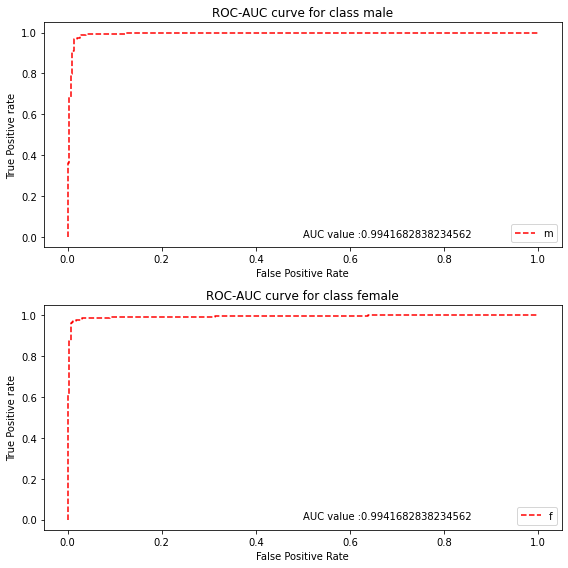

In [206]:
log_reg_model = LogisticRegression(penalty='l2', max_iter=500)
log_reg_model.fit(xtrain_roc, ytrain_roc)
ypred_roc = log_reg_model.predict_proba(xtest_roc)

roc_auc(ytest_roc, ypred_roc)

Importance of features 

In [16]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y)
le =le.transform(y)

In [18]:
print(le)
print(y)

[0 0 1 ... 1 0 0]
0       female
1       female
2         male
3       female
4       female
         ...  
3163      male
3164      male
3165      male
3166    female
3167    female
Name: gender, Length: 3168, dtype: object


Feature: 0, Score: -0.12345
Feature: 1, Score: 0.42800
Feature: 2, Score: -0.20553
Feature: 3, Score: -2.18011
Feature: 4, Score: 1.22936
Feature: 5, Score: -0.50472
Feature: 6, Score: 1.36081
Feature: 7, Score: -1.68022
Feature: 8, Score: 0.22383
Feature: 9, Score: -4.97451
Feature: 10, Score: 0.66338
Feature: 11, Score: -0.35120


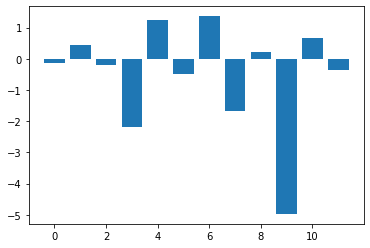

In [21]:

# logistic regression for feature importance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
# define dataset

# define the model
model = LogisticRegression()
# fit the model
model.fit(x, le)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([X for X in range(len(importance))], importance)
pyplot.show()